In [53]:
import os
from pathlib import Path
import laspy
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
import re
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import seaborn as sns
from datetime import datetime, timedelta
from numpy.polynomial.polynomial import Polynomial
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import scipy.io as sio
from scipy.stats import mode
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# from grid_utils import *
import numpy as np
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap

In [81]:
def get_cluster_volumes(grid_3d, clusters_3d, grid_files, cluster_files, res=.01):
    """
    Calculate the total volume of each cluster in each time step and store the data in a dataframe.
    
    Parameters:
    grid_3d (numpy.ndarray): 3D array of volume measurements (time_steps, alongshore_length, depth).
    clusters_3d (numpy.ndarray): 3D array of cluster IDs (time_steps, alongshore_length, depth).
    grid_files (list of str): List of filenames for the grid data (used to extract dates).
    res (float): Resolution of the grid (optional, default is 0.01).
    
    Returns:
    pd.DataFrame: A dataframe with columns: start_date, end_date, midpoint_date, volume, centroid_indices,
                  horizontal_extent, vertical_extent, and clusterID.
    """
    import re
    from datetime import datetime
    import numpy as np
    import pandas as pd

    # Regular expression to extract dates from filenames (assuming format YYYYMMDD)
    date_pattern = re.compile(r"(\d{8})")

    # Create a list to store the results
    results = []

    for time_step in range(grid_3d.shape[0]):
        # Extract the start and end dates for this time step from the grid file name
        date_matches = date_pattern.findall(grid_files[time_step])
        
        if len(date_matches) >= 2:
            start_date = datetime.strptime(date_matches[1], "%Y%m%d")
            end_date = datetime.strptime(date_matches[2], "%Y%m%d")
        else:
            continue  # Skip if the dates cannot be extracted
        
        # Calculate the midpoint date
        midpoint_date = start_date + (end_date - start_date) / 2 

        # Get the volume and cluster arrays for this time step
        volume_grid = grid_3d[time_step]
        cluster_grid = clusters_3d[time_step]

        # Get unique cluster IDs, ignoring background/noise clusters (-1)
        unique_clusters = np.unique(cluster_grid)
        unique_clusters = unique_clusters[unique_clusters != -1]

        # For each cluster, compute the total volume, centroid, and extents
        for cluster_id in unique_clusters:
            # Get the indices where this cluster ID is located
            cluster_indices = np.where(cluster_grid == cluster_id)

            # Compute total volume for this cluster
            total_volume = np.sum(volume_grid[cluster_indices]) * res

            # Compute centroid indices (alongshore and depth)
            if len(cluster_indices[0]) > 0:
                centroid_alongshore = int(np.mean(cluster_indices[0]))
                centroid_depth = int(np.mean(cluster_indices[1]))
                centroid_indices = (centroid_alongshore, centroid_depth)

                # Calculate horizontal extent (alongshore) and vertical extent (depth)
                horizontal_extent = (np.max(cluster_indices[0]) - np.min(cluster_indices[0])) * res*10
                vertical_extent = (np.max(cluster_indices[1]) - np.min(cluster_indices[1])) * res*10

                # Store the information in the results list
                results.append({
                    'start_date': start_date,
                    'end_date': end_date,
                    'midpoint_date': midpoint_date,
                    'volume': total_volume,
                    'centroid_indices': centroid_indices,
                    'horizontal_extent': horizontal_extent,
                    'vertical_extent': vertical_extent,
                    'clusterID': cluster_id
                })

    # Convert the results list into a pandas DataFrame
    df_results = pd.DataFrame(results).sort_values('volume', ascending=False)

    return df_results

# -------------------------------------------------------------------------------------------- #

def plot_centroid_bubbles(volume_df, volume_threshold=0, res=1, plotseawalls = False):
    """
    Scatter the centroids of the clusters in space as bubbles, sized by volume and colored by year.
    
    Parameters:
    volume_df (pd.DataFrame): A DataFrame containing the volume, centroids, and midpoint dates of clusters.
                              Must contain 'volume', 'centroid_indices', and 'midpoint_date' columns.
    volume_threshold (float): Minimum volume threshold for displaying the bubbles. Only volumes greater than this 
                              threshold will be plotted. Default is 0.
    res (int): Resolution scaling factor for seawall heights. Default is 1.
    """
        
    seawalls = [(280, 320), (615-45, 655), (1240, 1265), (1750, 1860), (1950, 2010)]
    seawallHeights = [9, 8, 4, 3.5, 5.5]
    if res != 1:
        seawallHeights = [x * 10 for x in seawallHeights]

    # Apply the volume threshold filter
    filtered_df = volume_df[volume_df['volume'] > volume_threshold]

    # Extract necessary columns: centroids (alongshore and depth), volumes, and years
    centroid_alongshore = [c[0] for c in filtered_df['centroid_indices']]
    centroid_depth = [c[1] for c in filtered_df['centroid_indices']]
    volumes = filtered_df['volume']
    years = pd.to_datetime(filtered_df['midpoint_date']).dt.year

    # Create the scatter plot
    plt.figure(figsize=(24, 6))
    
    # Scatter plot where:
    # X-axis is alongshore centroid, Y-axis is depth centroid
    # Bubble size is proportional to the volume, and color is based on the year
    scatter = plt.scatter(
        centroid_alongshore,  # X: Alongshore centroid
        centroid_depth,       # Y: Depth centroid
        s=volumes,            # Bubble size is proportional to the volume
        c=years,              # Color is based on the year
        cmap='viridis',       # Color map for the years
        alpha=0.75,           # Transparency of bubbles
        edgecolor='k',        # Edge color of the bubbles
        linewidth=0.5         # Edge line width
    )
    
    # Add rectangles representing seawalls starting from y=2 instead of 0
    if plotseawalls:
        for i, (start, end) in enumerate(seawalls):
            height = seawallHeights[i]
            if res != 1:
                rect = plt.Rectangle((start, 2*10), end - start, height - 2*10, color='gray', alpha=0.5)
            else:
                rect = plt.Rectangle((start, 2), end - start, height - 2, color='gray', alpha=0.5)
            plt.gca().add_patch(rect)
    
    # Add color bar for the years
    cbar = plt.colorbar(scatter)
    cbar.set_label('Year of Midpoint Date', fontsize=12)

    # Label the axes
    plt.xlabel('Alongshore Location', fontsize=14)
    plt.ylabel('Height', fontsize=14)
    plt.title('Volume Scatter Plot', fontsize=16)
    plt.gca().invert_xaxis()

    # Create a custom legend for the bubble sizes
    # Define some example volume values to illustrate different bubble sizes in the legend
    sizes = [10, 100, 500]
    for size in sizes:
        plt.scatter([], [], s=size, c='k', alpha=0.5, label=f'Volume: {size} m³')

    # Add the legend for bubble sizes (seawalls are not included in the legend)
    plt.legend(scatterpoints=1, frameon=False, labelspacing=.7, loc='upper left')

    # Show the plot
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------------------------------- #

def find_csv_files(directory, pattern="grid_1m.csv", erosion=True):
    """
    Traverse the given directory and find all CSV files that match the pattern.
    If erosion=True, include files without 'acc' in the name.
    If erosion=False, include only files with 'acc' in the name.
    Return a sorted list of full file paths based on the dates in the filenames.
    """
    csv_files = []
    
    # Regex pattern to extract date from the filename
    date_pattern = re.compile(r"(\d{8})")  # Looks for an 8-digit date (YYYYMMDD)

    # Walk through the directory and subdirectories
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file matches the conditions for erosion or acc
            if erosion and "acc" not in file and file.endswith(pattern):
                # Get the full path to the file
                full_path = os.path.join(root, file)
                
                # Extract the date from the filename
                match = date_pattern.search(file)
                if match:
                    date_str = match.group(1)  # Extract the first matched date
                    csv_files.append((full_path, date_str))
            elif not erosion and "acc" in file and file.endswith(pattern):
                # Get the full path to the file
                full_path = os.path.join(root, file)
                
                # Extract the date from the filename
                match = date_pattern.search(file)
                if match:
                    date_str = match.group(1)  # Extract the first matched date
                    csv_files.append((full_path, date_str))

    # Sort the list of tuples (path, date) based on the date string
    csv_files.sort(key=lambda x: x[1])  # Sort by the date part
    
    # Return only the paths, now sorted by date
    return [file[0] for file in csv_files]

# -------------------------------------------------------------------------------------------- #

# def plot_boxplots(volume_df, byYear=False, volume_cutoff=1):
#     """
#     Create box plots for the specified metrics on a logarithmic scale.
    
#     The function filters out clusters with a volume below volume_cutoff before plotting.
    
#     Parameters:
#         volume_df (pd.DataFrame): DataFrame containing the following columns:
#             - 'midpoint_date' (datetime): used to extract the year.
#             - 'volume' (float): cluster volume.
#             - 'centroid_indices' (tuple): (alongshore, depth) indices.
#             - 'horizontal_extent' (float): alongshore extent.
#             - 'vertical_extent' (float): vertical extent.
#         byYear (bool): If True, create a 4x1 subplot with box plots for each year.
#                        If False, create one plot with four side-by-side box plots for the overall distribution.
#         volume_cutoff (float): Minimum volume threshold; clusters with volume below this value are excluded.
#     """
#     # Filter out rows with volume below the cutoff
#     volume_df = volume_df[volume_df['volume'] >= volume_cutoff].copy()

#     # Ensure the midpoint_date is in datetime format and extract the year if needed.
#     if not pd.api.types.is_datetime64_any_dtype(volume_df['midpoint_date']):
#         volume_df['midpoint_date'] = pd.to_datetime(volume_df['midpoint_date'])
    
#     # Extract centroid elevation from centroid_indices (assumed to be the second element)
#     volume_df['centroid_elevation'] = volume_df['centroid_indices'].apply(lambda x: x[1])
    
#     if byYear:
#         # Create a 'year' column
#         volume_df['year'] = volume_df['midpoint_date'].dt.year
        
#         # Create a figure with 4 subplots (one per metric)
#         fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
        
#         # Boxplot for volume by year
#         sns.boxplot(x='year', y='volume', data=volume_df, ax=axes[0])
#         axes[0].set_title('Volume Distribution by Year (Log Scale)')
#         axes[0].set_xlabel('')
#         axes[0].set_yscale('log')
        
#         # Boxplot for centroid elevation by year
#         sns.boxplot(x='year', y='centroid_elevation', data=volume_df, ax=axes[1])
#         axes[1].set_title('Centroid Elevation Distribution by Year (Log Scale)')
#         axes[1].set_xlabel('')
#         axes[1].set_yscale('log')
        
#         # Boxplot for alongshore extent by year
#         sns.boxplot(x='year', y='horizontal_extent', data=volume_df, ax=axes[2])
#         axes[2].set_title('Alongshore Extent Distribution by Year (Log Scale)')
#         axes[2].set_xlabel('')
#         axes[2].set_yscale('log')
        
#         # Boxplot for vertical extent by year
#         sns.boxplot(x='year', y='vertical_extent', data=volume_df, ax=axes[3])
#         axes[3].set_title('Vertical Extent Distribution by Year (Log Scale)')
#         axes[3].set_xlabel('Year')
#         axes[3].set_yscale('log')
        
#         plt.tight_layout()
#         plt.show()
#     else:
#         # Create a single plot with four side-by-side box plots (overall distribution)
#         fig, ax = plt.subplots(figsize=(10, 6))
#         # Prepare data in a list: [Volume, Centroid Elevation, Alongshore Extent, Vertical Extent]
#         data = [
#             volume_df['volume'],
#             volume_df['centroid_elevation'],
#             volume_df['horizontal_extent'],
#             volume_df['vertical_extent']
#         ]
#         # Create the boxplot
#         ax.boxplot(data)
#         ax.set_yscale('log')
#         ax.set_xticklabels(['Volume (m³)', 'Centroid Elev. (m)', 'Alongshore Extent (m)', 'Vertical Extent (m)'], fontdict={'fontsize': 12, 'fontweight': 'bold'})
#         ax.set_title('Change Object Statistics', fontdict={'fontsize': 16, 'fontweight': 'bold'})
#         plt.tight_layout()
#         plt.show()

# # -------------------------------------------------------------------------------------------- #


def plot_boxplots(volume_df, byYear=False, volume_cutoff=1):
    """
    Create box plots for the specified metrics on a logarithmic scale.
    
    The function filters out clusters with a volume below volume_cutoff before plotting.
    It divides the centroid elevation by 10 and, instead of adding text labels to the figure,
    prints out a table of statistics (mean, median, Q1, Q3, min, and max) for each attribute.
    
    Parameters:
        volume_df (pd.DataFrame): DataFrame containing the following columns:
            - 'midpoint_date' (datetime): used to extract the year.
            - 'volume' (float): cluster volume.
            - 'centroid_indices' (tuple): (alongshore, depth) indices.
            - 'horizontal_extent' (float): alongshore extent.
            - 'vertical_extent' (float): vertical extent.
        byYear (bool): If True, create subplots for each metric by year.
                       If False, create one plot with four side-by-side box plots for the overall distribution.
        volume_cutoff (float): Minimum volume threshold; clusters with volume below this value are excluded.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    
    # Filter out rows with volume below the cutoff
    volume_df = volume_df[volume_df['volume'] >= volume_cutoff].copy()

    # Ensure the midpoint_date is in datetime format and extract the year if needed.
    if not pd.api.types.is_datetime64_any_dtype(volume_df['midpoint_date']):
        volume_df['midpoint_date'] = pd.to_datetime(volume_df['midpoint_date'])
    
    # Extract centroid elevation from centroid_indices (assumed to be the second element)
    volume_df['centroid_elevation'] = volume_df['centroid_indices'].apply(lambda x: x[1])
    # Divide the centroid elevation by 10
    volume_df['centroid_elevation'] = volume_df['centroid_elevation'] / 10
    
    metrics = ['volume', 'centroid_elevation', 'horizontal_extent', 'vertical_extent']
    metric_labels = ['Volume (m³)', 'Centroid Elev. (m)', 'Alongshore Extent (m)', 'Vertical Extent (m)']

    if byYear:
        # Create a 'year' column
        volume_df['year'] = volume_df['midpoint_date'].dt.year
        
        # Create a figure with 4 subplots (one per metric)
        fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
        
        for i, metric in enumerate(metrics):
            ax = axes[i]
            sns.boxplot(x='year', y=metric, data=volume_df, ax=ax)
            ax.set_title(f'{metric_labels[i]} Distribution by Year (Log Scale)')
            ax.set_xlabel('')
            ax.set_yscale('log')

        axes[-1].set_xlabel('Year')
        plt.tight_layout()
        plt.show()
        
        # Compute and print statistics for each metric for each year
        stats_by_year = {}
        for year, group in volume_df.groupby('year'):
            stats_by_year[year] = {
                metric: {
                    'Mean': group[metric].mean(),
                    'Median': group[metric].median(),
                    'Q1': group[metric].quantile(0.25),
                    'Q3': group[metric].quantile(0.75),
                    'Min': group[metric].min(),
                    'Max': group[metric].max()
                } for metric in metrics
            }
        for year in sorted(stats_by_year.keys()):
            print(f"Statistics for Year {year}:")
            df = pd.DataFrame(stats_by_year[year]).T
            print(df.to_string(float_format="%.2f"))
            print("\n")
            
    else:
        fig, ax = plt.subplots(figsize=(10, 6))
        data = [volume_df[metric] for metric in metrics]

        # Create boxplot
        box = ax.boxplot(data, patch_artist=True)
        ax.set_yscale('log')
        ax.set_xticklabels(metric_labels, fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_title('Erosion Change Object Statistics', fontdict={'fontsize': 16, 'fontweight': 'bold'})
        ax.set_ylabel('Magnitude (Log Scale)', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        plt.tight_layout()
        plt.show()
        
        # Compute and print overall statistics for each metric
        stats = {
            metric: {
                'Mean': volume_df[metric].mean(),
                'Median': volume_df[metric].median(),
                'Q1': volume_df[metric].quantile(0.25),
                'Q3': volume_df[metric].quantile(0.75),
                'Min': volume_df[metric].min(),
                'Max': volume_df[metric].max()
            } for metric in metrics
        }
        stats_df = pd.DataFrame(stats).T
        print("Overall Statistics:")
        print(stats_df.to_string(float_format="%.2f"))


In [ ]:
directory_path = '/Volumes/group/LiDAR/LidarProcessing/changedetection_m3c2/grid_output/delmar_grid_run_20240927' # second run

grid_files = find_csv_files(directory_path, pattern="grid_10x10cm.csv", erosion=True)
cluster_files = find_csv_files(directory_path, pattern="clusters_10x10cm.csv", erosion=True)

cropped_clusters= np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cleaned/ero_cropped_clusters_cleaned.npz")['data']
cropped_grid = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cleaned/ero_cropped_grid_cleaned.npz")['data']

In [68]:

volume_df = get_cluster_volumes(cropped_grid, cropped_clusters, grid_files, cluster_files)

# volume_df = pd.read_csv("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/volume_df.csv")

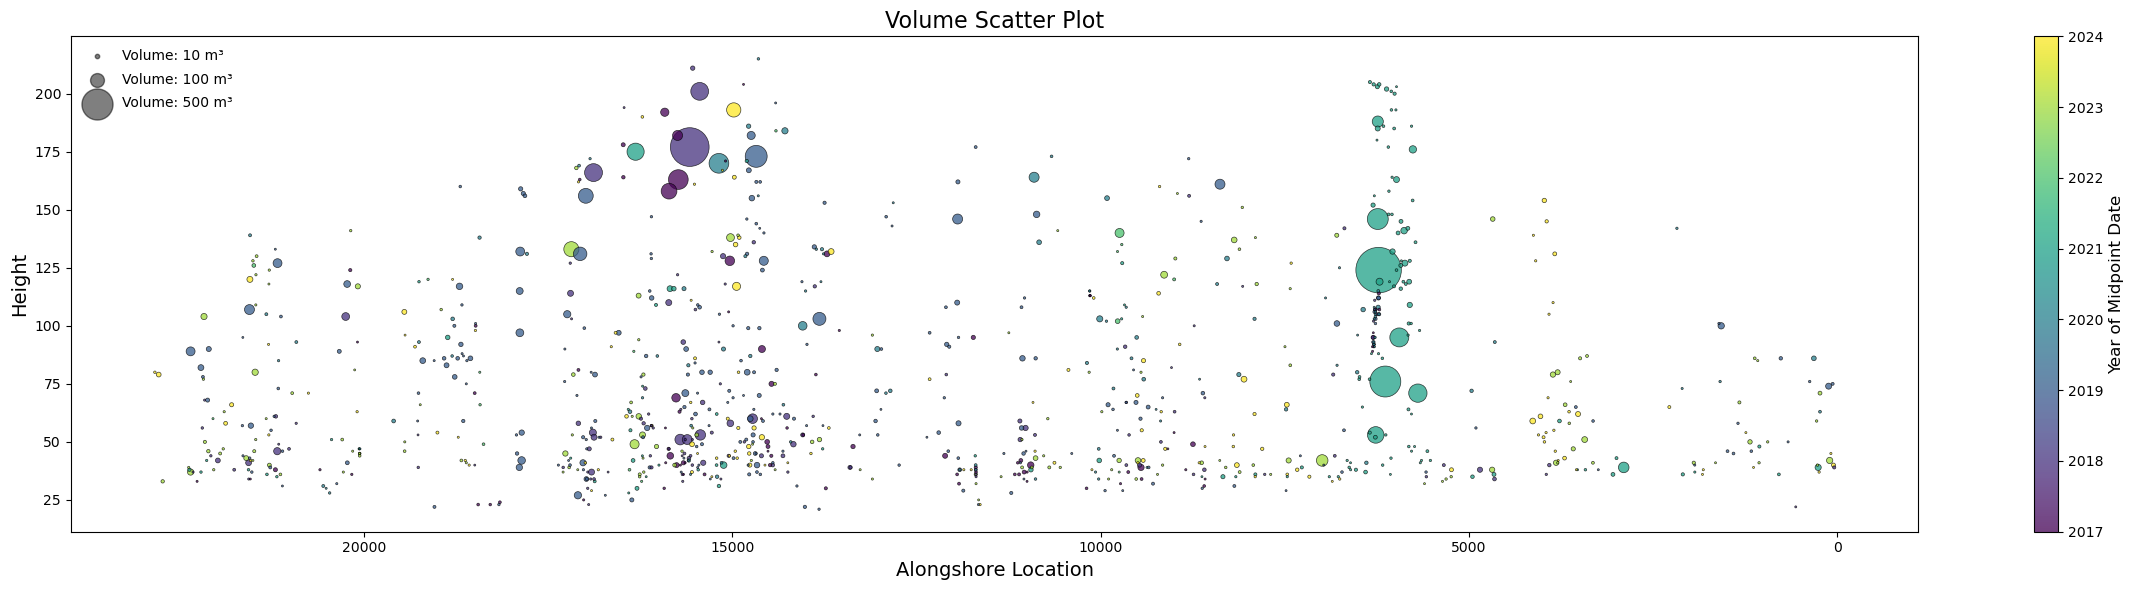

In [69]:
plot_centroid_bubbles(volume_df, volume_threshold=2, res=1, plotseawalls=False)

In [64]:
volume_df

,start_date,end_date,midpoint_date,volume,centroid_indices,horizontal_extent,vertical_extent,clusterID
6142,2021-05-04,2021-07-14,2021-06-08 12:00:00,1073.083457,"(6228, 124)",3.81,1.48,146
1386,2018-09-26,2018-10-05,2018-09-30 12:00:00,778.155005,"(15578, 177)",3.15,1.48,30
6276,2021-08-09,2021-09-13,2021-08-26 12:00:00,497.127999,"(6137, 76)",8.52,1.37,17
3267,2019-02-15,2019-02-19,2019-02-17 00:00:00,249.441509,"(14676, 173)",2.25,1.17,181
6001,2021-02-08,2021-03-09,2021-02-22 12:00:00,226.874213,"(6239, 146)",1.50,0.97,708
...,...,...,...,...,...,...,...,...
5508,2020-08-05,2020-08-14,2020-08-09 12:00:00,0.000000,"(11424, 148)",228.49,2.97,0
5524,2020-08-14,2020-08-20,2020-08-17 00:00:00,0.000000,"(11423, 148)",228.49,2.97,0
5536,2020-08-20,2020-09-18,2020-09-03 12:00:00,0.000000,"(11412, 148)",228.49,2.97,0
5560,2020-09-18,2020-10-20,2020-10-04 00:00:00,0.000000,"(11422, 148)",228.49,2.97,0


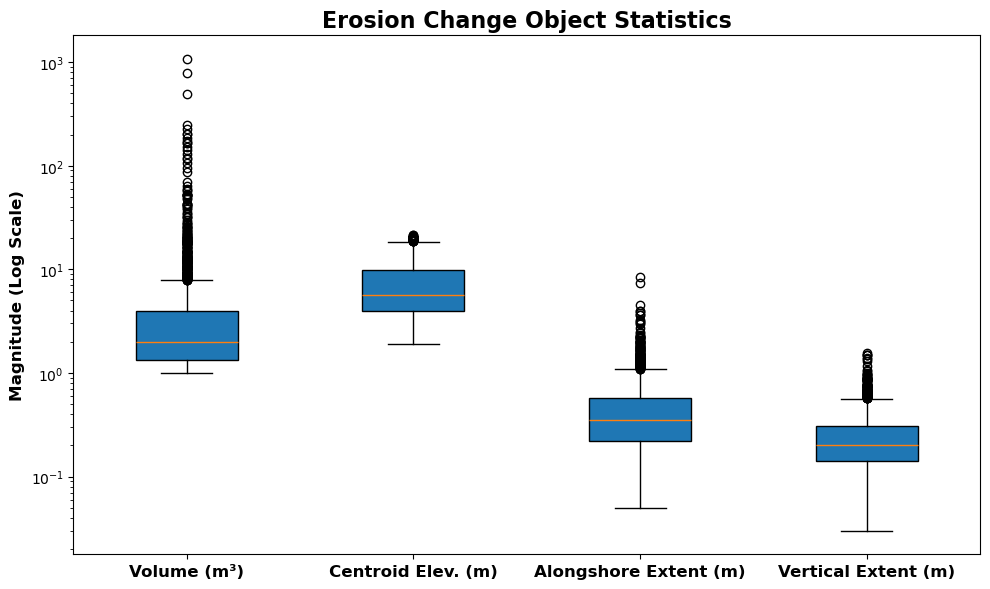

Overall Statistics:
                    Mean  Median   Q1   Q3  Min     Max
volume              6.31    1.98 1.33 3.95 1.00 1073.08
centroid_elevation  7.30    5.60 4.00 9.80 1.90   21.50
horizontal_extent   0.48    0.35 0.22 0.57 0.05    8.52
vertical_extent     0.25    0.20 0.14 0.31 0.03    1.56


In [82]:
plot_boxplots(volume_df, byYear=False)